In [1]:
import stringphylo
from stringphylo.mmd import string_kernel_fn_factory, make_rbf_kernel_fn, perm_mmd_test

import numpy as np
import pandas as pd
import os

from skbio.stats.composition import clr, closure, multiplicative_replacement

from gpflow.kernels import Linear

import logging
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logging.getLogger("utils").setLevel('INFO')

# Data preparation

For the MMD calculation we will only use the ASV tables.

In [47]:
# load ASV table and phenotypes
asv_table = pd.read_csv("../data/asv_table.csv").set_index("sample_id")
logger.info(f"ASV table shape: {asv_table.shape}")
assert np.all(np.isnan(asv_table).sum()==0)

2022-12-06 15:54:16 INFO     ASV table shape: (394, 525)


# Formatting string kernels

Requires loading the $Q$ matrix for each value of the string kernel hyperparamters. Here we only consider the spectrum kernel with $k$-mer length of 9.

In [48]:
kernel_load_path = "../data/ravel_stringkernels"
asv_names = asv_table.columns

def read_feather(filepath):
    out = pd.read_feather(filepath)
    if "rownames" in out:
        return out.set_index("rownames")
    else:
        logger.warning("'rownames' not available for use as index")
        return out.set_index("C0")
    
def parse_stringkernel_name(x):
    return dict([xx.split("__", 1) for xx in x.replace(".feather", "").split("____")]) 

# load the string kernel Q matrices
kernel_files = [
    f for f in os.listdir(kernel_load_path)
    if os.path.isfile(os.path.join(kernel_load_path, f))
]
logger.info(f"Found {len(kernel_files)} string kernel files")

loaded_kernels = []
for i, f in enumerate(kernel_files):
    logger.debug(f"Loading kernel {i} of {len(kernel_files)}")
    Q = read_feather(os.path.join(kernel_load_path, f))
    if not Q.columns.equals(Q.index):
        logger.warning(f"Columns and index don't match for {kernel_files[k]}")
        continue
    
    # reorder columns of Q to match the ASV table
    loaded_kernels.append(
        dict({'Q' : Q.loc[asv_names,asv_names].astype(float)}, **parse_stringkernel_name(f))
    )
logger.info(f"Loaded {len(loaded_kernels)} spectrum kernels")

2022-12-06 15:54:19 INFO     Found 29 string kernel files
2022-12-06 15:54:19 DEBUG    Loading kernel 0 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 1 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 2 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 3 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 4 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 5 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 6 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 7 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 8 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 9 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 10 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 11 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 12 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 13 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 14 of 29
2022-12-06 15:54:19 DEBUG    Loading kernel 15 of 29
2022-12-06 15:54:20 DEBUG    Loading kernel 16 of 29
2022-12-06 15:54:20 DEBUG    Loading kernel 17 of 2

# Setting up the MMD calculation

We split the samples randomly into two groups and apply the CLR transform.

In [55]:
# use k=9
Q = loaded_kernels[20]['Q']
k = loaded_kernels[20]['k']

# split into two groups
rng = np.random.default_rng(1234)

# random group membersip for samples
n = asv_table.shape[0]
group_idxs = np.array_split(
    rng.permutation(n),
    2
)

# ASV counts for each group
X0 = asv_table.iloc[group_idxs[0],:].to_numpy().astype(float)
X1 = asv_table.iloc[group_idxs[1],:].to_numpy().astype(float)

# apply the CLR transform before computing the kernels
def clr_transform(x):
    return clr(closure(multiplicative_replacement(x)))

X0_clr = clr_transform(X0)
X1_clr = clr_transform(X1)

## Kernel two-sample test using spectrum and RBF kernels

In [56]:
# MMD two-sample test with spectrum kernel
n_perms = 100

mmd_perm_vals_string, mmd_obs_string, p_value_string = perm_mmd_test(
    X0_clr,
    X1_clr,
    kernel_maker=string_kernel_fn_factory(Q, 1.0, False),
    n_perms=n_perms,
    rng=rng
)

# MMD two-sample test with RBF kernel
mmd_perm_vals_rbf, mmd_obs_rbf, p_value_rbf = perm_mmd_test(
    X0_clr,
    X1_clr,
    kernel_maker=lambda x0, x1: make_rbf_kernel_fn(x0, x1, rescale=True),
    n_perms=n_perms,
    rng=rng
)

Neither kernel rejects the null hypothesis (that the two groups from the same population). We expect this as we have split the samples at random.

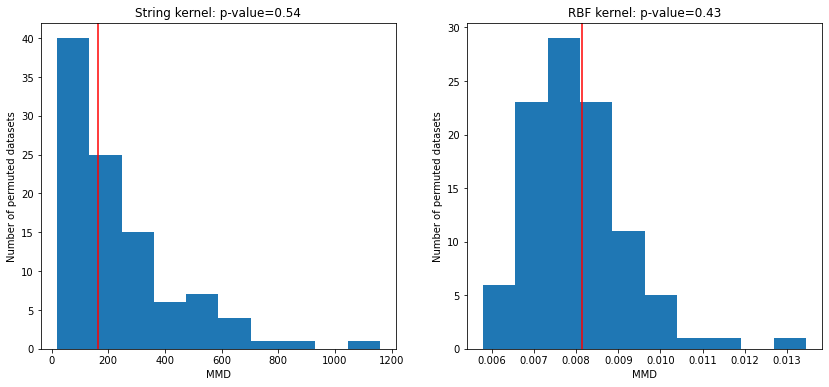

In [57]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].hist(mmd_perm_vals_string)
axes[0].axvline(mmd_obs_string, c="red")
axes[0].set_title(f"String kernel: p-value={p_value_string:.2f}")

axes[1].hist(mmd_perm_vals_rbf)
axes[1].axvline(mmd_obs_rbf, c="red")
axes[1].set_title(f"RBF kernel: p-value={p_value_rbf:.2f}")

for ax in axes:
    ax.set_xlabel("MMD")
    ax.set_ylabel("Number of permuted datasets")